#  Background bias study

Make sure the system is the expected one. 

In [1]:
from platform import python_version
import sys

print(sys.executable)
print(python_version())

/Users/chrispap/.pyenv/versions/3.9.5/bin/python3.9
3.9.5


Import all the necessary modules.

In [2]:
import numpy as np
import awkward as ak
import uproot
from coffea.nanoevents import NanoEventsFactory, TreeMakerSchema, BaseSchema
from coffea import processor
from coffea.nanoevents.methods import candidate
import matplotlib.pyplot as plt
import mplhep
import hist
import gc

mplhep.style.use("CMS")
ak.behavior.update(candidate.behavior)

Define processor

In [15]:
class SUEPsProcessor(processor.ProcessorABC):
    def rhoProfile(self, jet, tracks, deltaR, dr=0.05):
        rho_space = np.linspace(0, 1.5, int(1.5/dr)+1)
        rho_values = []
        for i in range(0, int(1.5/dr)):
            ring = (deltaR > rho_space[i]) & (deltaR < rho_space[i+1])
            if len(rho_values) == 0:
                rho_values = ak.to_numpy(ak.sum(tracks[ring].pt, axis=1)/(dr*jet.pt))
                rho_values = rho_values.reshape(len(rho_values),1)
            else:
                rho_values = np.append(rho_values, ak.to_numpy(ak.sum(tracks[ring].pt, axis=1)/(dr*jet.pt)).reshape(len(rho_values),1),1)
        return rho_values
    
    def rho(self, number, jet, tracks, deltaR, dr=0.05):
        r_start = number*dr
        r_end = (number+1)*dr
        ring = (deltaR > r_start) & (deltaR < r_end)
        rho_values = ak.sum(tracks[ring].pt, axis=1)/(dr*jet.pt)
        return rho_values
    
    def sphericityTensor(self, particles):
        particles_p = np.sqrt(particles.x * particles.x + particles.y * particles.y + particles.z * particles.z)
        norm = ak.sum(particles_p * particles_p, axis=1)
        s = np.array(
            [
                [
                    ak.sum(particles.x * particles.x, axis=1)/norm,
                    ak.sum(particles.x * particles.y, axis=1)/norm,
                    ak.sum(particles.x * particles.z, axis=1)/norm
                ],
                [
                    ak.sum(particles.y * particles.x, axis=1)/norm,
                    ak.sum(particles.y * particles.y, axis=1)/norm,
                    ak.sum(particles.y * particles.z, axis=1)/norm
                ],
                [
                    ak.sum(particles.z * particles.x, axis=1)/norm,
                    ak.sum(particles.z * particles.y, axis=1)/norm,
                    ak.sum(particles.z * particles.z, axis=1)/norm
                ]
            ]
        )
        return s

    def sphericity(self, s):
        s = np.nan_to_num(s)
        s_eigvalues = np.sort(np.linalg.eigvals(np.moveaxis(s, 2, 0)))
        sphericity = 1.5*(s_eigvalues[:,0]+s_eigvalues[:,1])
        return sphericity

    def process(self, events):
        dataset = events.metadata['dataset']
        
        # Control variables
        boost = True         # If true, boost the event before sphericity calculation
        suepTrks = False     # If true, use only the tracks within the SUEP AK15 jet for nTracks
        suepTrksSph = True   # If true, use only the tracks within the SUEP AK15 jet for sphericity
        
        # Constants
        INTEGRATED_LUMINOSITY = 137.19*1000 # fb^{-1} to pb^{-1}
        HT_CUTOFF = 500
        MASS_PION = 0.13957
        FATJET_PT_CUTOFF = 150
        FATJET_SIZE = 1.5
        TRACK_PT_CUTOFF = 1
        
        # Load all the necessary variables 
        ht = events.HT
        htRequirement = ht > HT_CUTOFF
        weights = INTEGRATED_LUMINOSITY*events.CrossSection[htRequirement]/len(events)
        tracks = events.Tracks[htRequirement]
        tracks_pt = np.sqrt(tracks.x**2 + tracks.y**2)
        tracks_eta = np.arcsinh(tracks.z / tracks_pt)
        tracks_phi = np.arctan2(tracks.y, tracks.x)
        tracks_mass = MASS_PION*(tracks_pt > 0)
        tracks_qualityMask = (tracks_pt > TRACK_PT_CUTOFF) & (abs(tracks_eta) < 2.5) & \
                             (tracks.fromPV0 >= 2) & tracks.matchedToPFCandidate
        JetsAK15 = ak.zip(
            {
                "pt": events.JetsAK15.pt[htRequirement],
                "eta": events.JetsAK15.eta[htRequirement],
                "phi": events.JetsAK15.phi[htRequirement],
                "mass": events.JetsAK15.mass[htRequirement],
                "chMult": events.JetsAK15.chargedMultiplicity[htRequirement]
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )
        JetsAK15 = JetsAK15[JetsAK15.pt > FATJET_PT_CUTOFF]
        JetsAK15 = JetsAK15[:,:2]

        # Find the AK15 jet hat corresponds to the 
        suepJets = JetsAK15[ak.argsort(JetsAK15.chMult, ascending=False)][:,0]
        beta = suepJets.pvec/suepJets.energy
        tracks_final = ak.zip(
            {
                "pt": tracks_pt,
                "eta": tracks_eta,
                "phi": tracks_phi,
                "mass": tracks_mass,
                "charge": events.Tracks.charge[htRequirement]
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )

        tracks_final = tracks_final[tracks_qualityMask]

        # Calculate nTracks - in jet of event
        nTracks = None
        if suepTrks:
            nTracks = ak.sum(tracks_final[tracks_final.delta_r(suepJets) < FATJET_SIZE].pt > 0, axis=1)
        else:
            nTracks = ak.sum(tracks_final.pt > 0, axis=1)

        if suepTrksSph:
            tracks_final = tracks_final[tracks_final.delta_r(suepJets) < FATJET_SIZE]

        tracks_boosted = tracks_final
        if boost:
            tracks_boosted = tracks_final.boost(-beta)

        # Calculate sphericity
        sTensor = self.sphericityTensor(tracks_boosted)
        sph = self.sphericity(sTensor)
        
        # Calculate rho
        deltaR = tracks_final.delta_r(suepJets)
        rho2 = self.rho(2, suepJets, tracks_final, deltaR)
        rho3 = self.rho(3, suepJets, tracks_final, deltaR)

        hist1 = (
            hist.Hist.new
            .Reg(50, 0, 250, name="nTracks")
            .Reg(50, 0, 1, name="sphericity")
            .Reg(100, 0, 20, name="rho0")
            .Reg(100, 0, 20, name="rho1")
            .Weight()
            .fill(
                nTracks=nTracks,
                sphericity=sph,
                rho0=rho0,
                weight=weights
            )
        )

        hist_rhos = []
        for i in range(10):
            hist_rhos[i] = (
                hist.Hist.new.Reg(100, 0, 20, name="rho2")
                .Weight().fill(rho2=rho2,weight=weights)
            )

        return {
            dataset: {
                "entries": len(events),
                "hist1": hist1,
                "hist2": hist2,
            }
        }

    def postprocess(self, accumulator):
        return accumulator

Run over the samples

In [10]:
baseDir = '/Users/chrispap/QCD/ak15/QCD/'
tmFileset = {
    'CMSSW': [
        baseDir + 'Autumn18.QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8_0_RA2AnalysisTree.root',
        #baseDir + 'Autumn18.QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8_1_RA2AnalysisTree.root',
        #baseDir + 'Autumn18.QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8_2_RA2AnalysisTree.root',
        #baseDir + 'Autumn18.QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8_3_RA2AnalysisTree.root',
        baseDir + 'Autumn18.QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8_0_RA2AnalysisTree.root',
        #baseDir + 'Autumn18.QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8_1_RA2AnalysisTree.root',
        #baseDir + 'Autumn18.QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8_2_RA2AnalysisTree.root',
        #baseDir + 'Autumn18.QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8_3_RA2AnalysisTree.root',
        #baseDir + 'Autumn18.QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8_4_RA2AnalysisTree.root',
        baseDir + 'Autumn18.QCD_HT2000toInf_TuneCP5_13TeV-madgraphMLM-pythia8_0_RA2AnalysisTree.root',
        #baseDir + 'Autumn18.QCD_HT2000toInf_TuneCP5_13TeV-madgraphMLM-pythia8_1_RA2AnalysisTree.root',
        #baseDir + 'Autumn18.QCD_HT2000toInf_TuneCP5_13TeV-madgraphMLM-pythia8_2_RA2AnalysisTree.root',
        #baseDir + 'Autumn18.QCD_HT2000toInf_TuneCP5_13TeV-madgraphMLM-pythia8_3_RA2AnalysisTree.root',
        #baseDir + 'Autumn18.QCD_HT2000toInf_TuneCP5_13TeV-madgraphMLM-pythia8_4_RA2AnalysisTree.root',
    ],
}

tmOut = processor.run_uproot_job(
    tmFileset,
    treename="TreeMaker2/PreSelection",
    processor_instance=SUEPsProcessor(),
    executor=processor.futures_executor,
    executor_args={
        "schema": TreeMakerSchema,
        "workers": 4
    },
    chunksize=50000,
)
histo = tmOut['CMSSW']['hist']

Processing:   0%|          | 0/3 [00:00<?, ?chunk/s]

/Users/chrispap/.pyenv/versions/3.9.5/lib/python3.9/site-packages/awkward/_connect/_numpy.py:180: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/Users/chrispap/.pyenv/versions/3.9.5/lib/python3.9/site-packages/awkward/_connect/_numpy.py:180: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(


In [17]:
tmOut2 = processor.run_uproot_job(
    tmFileset,
    treename="TreeMaker2/PreSelection",
    processor_instance=TreeMakerProcessor(),
    executor=processor.futures_executor,
    executor_args={
        "schema": TreeMakerSchema,
        "workers": 4
    },
    chunksize=50000,
)
histo2 = tmOut2['CMSSW']['hist']

Processing:   0%|          | 0/3 [00:00<?, ?chunk/s]

/Users/chrispap/.pyenv/versions/3.9.5/lib/python3.9/site-packages/awkward/_connect/_numpy.py:180: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/Users/chrispap/.pyenv/versions/3.9.5/lib/python3.9/site-packages/awkward/_connect/_numpy.py:180: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(
/Users/chrispap/.pyenv/versions/3.9.5/lib/python3.9/site-packages/awkward/_connect/_numpy.py:180: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(
/Users/chrispap/.pyenv/versions/3.9.5/lib/python3.9/site-packages/awkward/_connect/_numpy.py:180: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/Users/chrispap/.pyenv/versions/3.9.5/lib/python3.9/site-packages/awkward/_connect/_numpy.py:180: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(


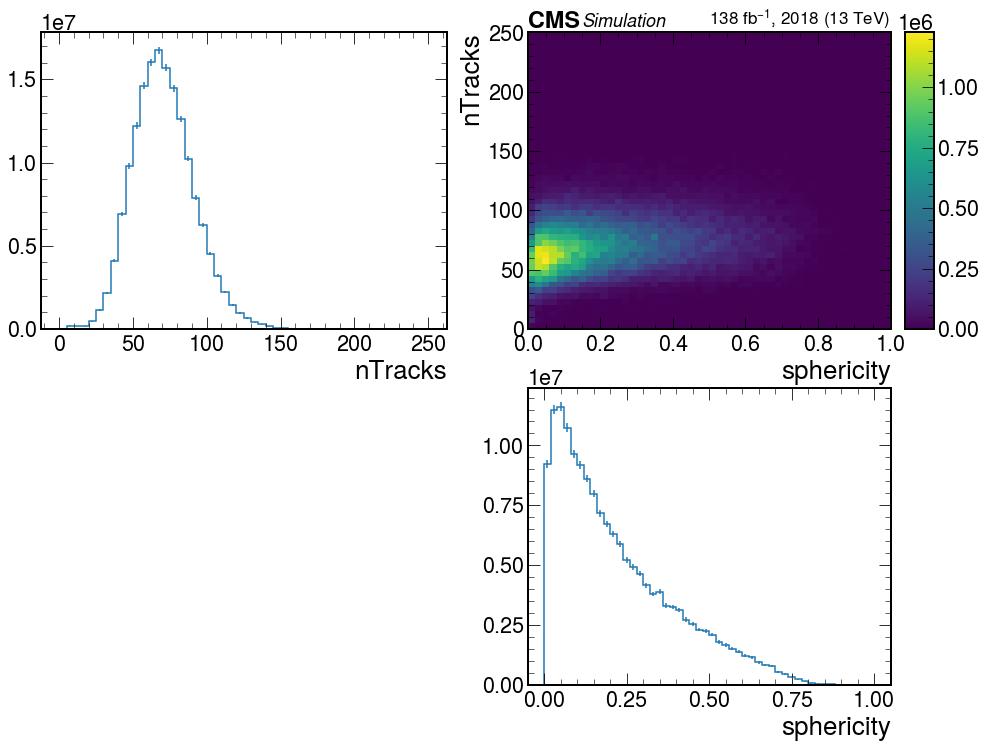

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

mplhep.histplot(histo.project("sphericity"), ax=axs[1,1])
mplhep.histplot(histo.project("nTracks"), ax=axs[0,0])
mplhep.hist2dplot(histo.project("sphericity","nTracks"), ax=axs[0,1])

# Overall - both left and right annotation
mplhep.cms.label('', lumi=138, year=2018, fontsize=18)

fig.delaxes(axs[1,0])
l, b, w, h = axs[1,1].get_position().bounds
ll, bb, ww, hh = axs[0,1].get_position().bounds
axs[1,1].set_position([l, b, ww, h])

plt.show()

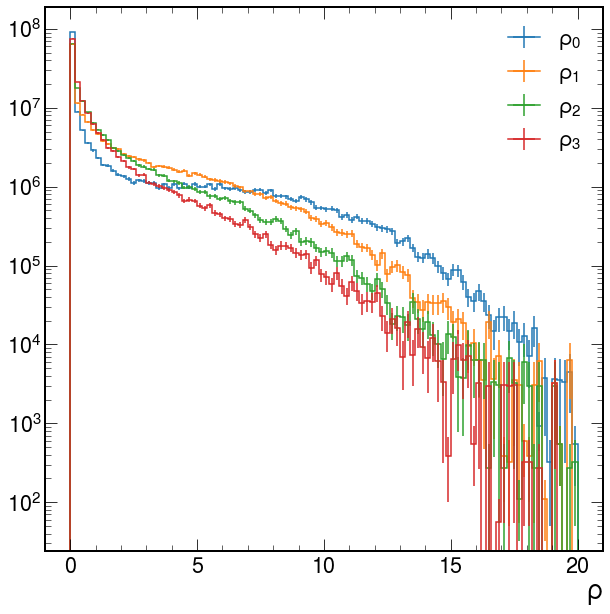

In [18]:
ax0 = plt.gca()
mplhep.histplot(histo.project("rho0"), ax=ax0, label=r"$\rho_{0}$")
ax0.set_yscale('log')
mplhep.histplot(histo.project("rho1"), ax=ax0, label=r"$\rho_{1}$")
mplhep.histplot(histo2.project("rho2"), ax=ax0, label=r"$\rho_{2}$")
mplhep.histplot(histo2.project("rho3"), ax=ax0, label=r"$\rho_{3}$")
ax0.set_xlabel(r"$\rho$")
ax0.legend()

plt.show()

In [ ]:
histo.project("rho0")

In [ ]:
mplhep.hist2dplot(histo.project("sphericity","nTracks"))
mplhep.histplot(histo.project("sphericity","nTracks").profile(axis=1))

In [ ]:
mplhep.hist2dplot(histo.project("rho0","rho1"))

# Overall - both left and right annotation
mplhep.cms.label('', lumi=138, year=2018, fontsize=18)

#plt.xlim(0.00001, 10)
#plt.ylim(0.00001, 10)
#plt.xscale('log')
#plt.yscale('log')

In [23]:
histo.project("rho0")

In [25]:
histo.profile("rho0")

Hist(
  Regular(50, 0, 250, name='nTracks', label='nTracks'),
  Regular(50, 0, 1, name='sphericity', label='sphericity'),
  Regular(100, 0, 20, name='rho1', label='rho1'),
  storage=Mean()) # Sum: Mean(count=1.6579e+08, value=2.00686, variance=16142.3)